<a href="https://colab.research.google.com/github/komalmuktal/Scene-Recognition/blob/main/Scene_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import itertools
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader, Subset
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import torchvision.models as models
import torchvision

In [ ]:
data_dir1='/content/Images'

In [ ]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(data_dir1, transform = transformations)

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 256, 256]) 0


tensor([[[0.8039, 0.7922, 0.7176,  ..., 0.3882, 0.4980, 0.5882],
         [0.6235, 0.5961, 0.5725,  ..., 0.4588, 0.4627, 0.5686],
         [0.3765, 0.3529, 0.3412,  ..., 0.5686, 0.4275, 0.5451],
         ...,
         [0.2627, 0.2510, 0.2510,  ..., 0.4078, 0.2588, 0.2078],
         [0.3176, 0.3373, 0.3686,  ..., 0.4275, 0.2471, 0.2118],
         [0.1804, 0.2314, 0.2510,  ..., 0.4941, 0.3608, 0.2941]],

        [[0.8353, 0.8196, 0.7412,  ..., 0.3725, 0.5137, 0.6039],
         [0.6667, 0.6392, 0.6157,  ..., 0.4392, 0.4745, 0.5843],
         [0.4039, 0.3725, 0.3608,  ..., 0.5490, 0.4314, 0.5529],
         ...,
         [0.2980, 0.2667, 0.2627,  ..., 0.4118, 0.2902, 0.2471],
         [0.3373, 0.3412, 0.3725,  ..., 0.4235, 0.2902, 0.2667],
         [0.1882, 0.2275, 0.2471,  ..., 0.4863, 0.3922, 0.3373]],

        [[0.8039, 0.7804, 0.6941,  ..., 0.5647, 0.4510, 0.5490],
         [0.5373, 0.4902, 0.4549,  ..., 0.6235, 0.4392, 0.5333],
         [0.3725, 0.3451, 0.3294,  ..., 0.6941, 0.4588, 0.

In [ ]:
classes = os.listdir(data_dir1)
print(classes)

['auditorium', 'subway', 'laboratorywet', 'pantry', 'classroom', 'restaurant_kitchen', 'buffet', 'winecellar', 'hospitalroom', 'computerroom', 'dining_room', 'concert_hall', 'office', 'library', 'poolinside', 'kindergarden', 'livingroom', 'inside_subway', 'gameroom', 'bar', 'bowling', 'operating_room', 'laundromat', 'florist', 'church_inside', 'casino', 'forest', 'bathroom', 'stairscase', 'shoeshop', 'gym', 'corridor', 'prisoncell', 'lobby', 'cloister', 'clothingstore', 'artstudio', 'bakery', 'kitchen', 'jewelleryshop', 'meeting_room', 'warehouse', 'videostore', 'buildings', 'mountain', 'elevator', 'waitingroom', 'studiomusic', 'nursery', 'restaurant', 'locker_room', 'sea', 'children_room', 'fastfood_restaurant', 'museum', 'closet', 'mall', 'garage', 'bedroom', 'hairsalon', 'toystore', 'movietheater', 'glacier', 'inside_bus', 'dentaloffice', 'street', 'tv_studio', 'bookstore', 'greenhouse', 'trainstation', 'deli', 'airport_inside', 'grocerystore']


Label: forest (Class No: 27)


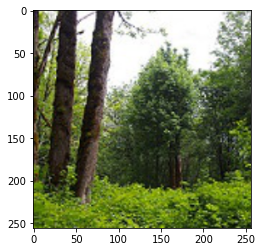

In [ ]:
# helper function to see the image and its corresponding label:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

index = random.randrange(len(dataset))
show_sample(*dataset[index])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
len(dataset)

29654

In [ ]:
from torch.utils.data import random_split
import torchvision.models as models
train_ds, val_ds, test_ds = random_split(dataset, [23723, 2965, 2966])
len(train_ds), len(val_ds), len(test_ds)


(23723, 2965, 2966)

In [ ]:
batch_size=25

In [ ]:
from torch.utils.data.dataloader import DataLoader
#we'll create training and validation dataloaders using DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

In [ ]:
# function to visualize batches:
from torchvision.utils import make_grid
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))
        break

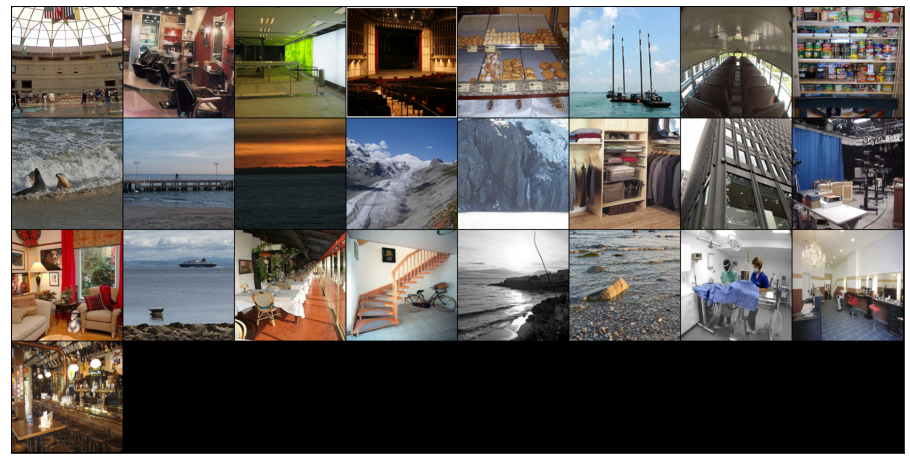

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
#     label = label > threshold
    label = label.unsqueeze(1) + to_device(torch.zeros(len(output), len(classes)), device) == to_device(torch.from_numpy(np.arange(len(classes))), device)
    
    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        score = F_score(out, labels)         # Calculate score
        return {'val_loss': loss.detach(), 'val_acc': acc, 'val_score': score}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()  # Combine scores
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'], result['val_score']))

In [ ]:
class vgg19_bn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg19_bn(pretrained=True)
       
        num_ftrs=self.network.classifier[6].in_features
        self.network.classifier[6]= nn.Linear(num_ftrs, len(classes))
        
        
        # features=list
  #      (self.network.classifier.children())[:-1]
        # features.extend([nn.Linear(num_ftrs, len(classes))])
        # self.network.classifier=nn.Sequential(*features)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.classifier.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs')
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(vgg19_bn(), device)

In [ ]:
model

vgg19_bn(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [ ]:
model.freeze()

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.023666666820645332,
  'val_loss': 4.286542892456055,
  'val_score': 0.002185463672503829}]

In [ ]:
epochs = 10
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, 0.00005, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0000, train_loss: 2.1905, val_loss: 0.9829, val_acc: 0.7393, val_score: 0.4661



Epoch [1], last_lr: 0.0000, train_loss: 0.9243, val_loss: 0.6485, val_acc: 0.8152, val_score: 0.5939



Epoch [2], last_lr: 0.0001, train_loss: 0.5625, val_loss: 0.6430, val_acc: 0.8154, val_score: 0.5058



Epoch [3], last_lr: 0.0000, train_loss: 0.3304, val_loss: 0.5663, val_acc: 0.8364, val_score: 0.4880



Epoch [4], last_lr: 0.0000, train_loss: 0.1880, val_loss: 0.6523, val_acc: 0.8341, val_score: 0.4618



Epoch [5], last_lr: 0.0000, train_loss: 0.0991, val_loss: 0.6489, val_acc: 0.8486, val_score: 0.4658



Epoch [6], last_lr: 0.0000, train_loss: 0.0475, val_loss: 0.6393, val_acc: 0.8554, val_score: 0.4515



Epoch [7], last_lr: 0.0000, train_loss: 0.0232, val_loss: 0.6638, val_acc: 0.8581, val_score: 0.4358



Epoch [8], last_lr: 0.0000, train_loss: 0.0114, val_loss: 0.6473, val_acc: 0.8671, val_score: 0.4237



Epoch [9], last_lr: 0.0000, train_loss: 0.0084, val_loss: 0.6365, val_acc: 0.8674, val_score: 0.4297
CPU times: user 52min 48s, sys: 1h 1min 26s, total: 1h 54min 15s
Wall time: 1h 55min 54s


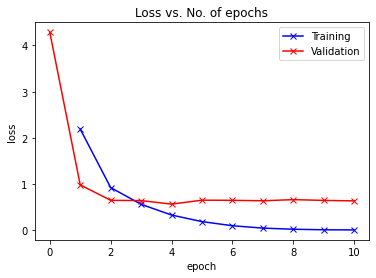

In [ ]:
plot_losses(history)

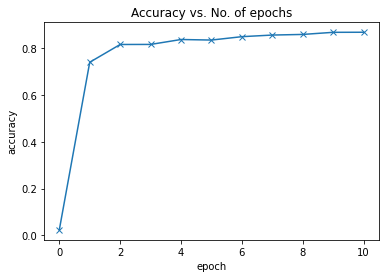

In [ ]:
plot_accuracies(history)

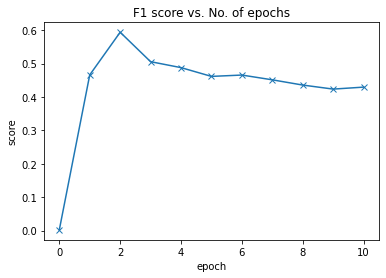

In [ ]:
plot_scores(history)

In [ ]:
import joblib
joblib.dump(model, 'vgg16_model.h5',protocol=4)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.8674444556236267,
 'val_loss': 0.6365397572517395,
 'val_score': 0.42966949939727783}

In [ ]:
test_dataloader = DataLoader(test_ds, batch_size*2,)
test_dataloader = DeviceDataLoader(test_dataloader, device)
result = evaluate(model, test_dataloader)
result

{'val_acc': 0.8772916793823242,
 'val_loss': 0.5603325963020325,
 'val_score': 0.42477351427078247}

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[1720]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://www.gardeningknowhow.com/wp-content/uploads/2013/10/greenhouse.jpg", "image4.jpg")

In [ ]:
loaded_model = model

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")


In [ ]:
predict_external_image('image4.jpg')

In [ ]:
class vgg19_bn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg19(pretrained=True)
       
        num_ftrs=self.network.classifier[6].in_features
        self.network.classifier[6]= nn.Linear(num_ftrs, len(classes))
        